# Tahap 1: Problem Statement dan Tujuan Proyek

## Identifikasi Problem Statement
Surge pricing adalah strategi penyesuaian harga otomatis berdasarkan lonjakan permintaan. Dalam layanan taksi online, surge pricing dapat meningkatkan keuntungan namun juga berisiko menurunkan kepuasan pelanggan jika dianggap tidak transparan atau tidak adil.

**Permasalahannya:**
- Bagaimana cara memprediksi apakah sebuah perjalanan akan mengalami surge pricing atau tidak?

- Apa saja faktor utama yang memengaruhi terjadinya surge pricing?

Model prediksi ini dibutuhkan untuk membantu sistem pricing otomatis menjadi lebih akurat, transparan, dan dapat diandalkan oleh perusahaan maupun pengguna.

## Tujuan Proyek
- MempredMengembangkan model klasifikasi biner yang mampu memprediksi apakah surge pricing akan terjadi atau tidak (0 = Tanpa Lonjakan, 1 = Ada Lonjakan).

- Mengidentifikasi fitur-fitur kunci yang berperan penting dalam prediksi surge pricing, seperti jenis kendaraan, jarak tempuh, dan karakteristik pelanggan.

- Menyediakan insight bagi perusahaan untuk menyusun strategi harga dan promosi yang lebih efektif.

## Output Tahap
- Problem statement yang jelas dan kontekstual:
    - "Bagaimana memprediksi lonjakan harga dalam layanan taksi online secara akurat berdasarkan data karakteristik perjalanan dan pelanggan?"

- Tujuan proyek yang terukur:
    - Membuat model klasifikasi dengan metrik evaluasi makro-F1 yang optimal.

    - Mendukung pengambilan keputusan bisnis melalui analitik prediktif.

# Tahap 2: Data Preprocessing

Tujuan Langkah Ini:
- Membersihkan data dari nilai kosong, duplikat, atau anomali.
- Mengubah data mentah menjadi bentuk yang siap dianalisis dan dimodelkan.

### Import libraries

In [1]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, roc_auc_score
import streamlit as st


pd.set_option("display.max_columns", None) #untuk menampilkan semua kolom dataframe
pd.set_option("display.max_rows", None) #untuk menampilkan semua baris dataframe

### Load Dataset & Cek Struktur Awal

In [2]:
# Load dataset
df = pd.read_csv("sigma_cabs.csv")

In [3]:
# Lihat 5 baris pertama
df.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


### Cek Informasi Umum dan Nilai Kosong

In [4]:
# Cek struktur data
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131662 entries, 0 to 131661
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_ID                      131662 non-null  object 
 1   Trip_Distance                131662 non-null  float64
 2   Type_of_Cab                  111452 non-null  object 
 3   Customer_Since_Months        125742 non-null  float64
 4   Life_Style_Index             111469 non-null  float64
 5   Confidence_Life_Style_Index  111469 non-null  object 
 6   Destination_Type             131662 non-null  object 
 7   Customer_Rating              131662 non-null  float64
 8   Cancellation_Last_1Month     131662 non-null  int64  
 9   Var1                         60632 non-null   float64
 10  Var2                         131662 non-null  int64  
 11  Var3                         131662 non-null  int64  
 12  Gender                       131662 non-nul

### Dataset Overview

Dataset ini terdiri dari **131.662 entri** dan **14 kolom**, dengan deskripsi sebagai berikut:

| Nama Kolom                    | Deskripsi                                                                 |
|------------------------------|---------------------------------------------------------------------------|
| `Trip_ID`                    | ID unik untuk setiap perjalanan.                                          |
| `Trip_Distance`              | Jarak perjalanan yang ditempuh (dalam kilometer).                         |
| `Type_of_Cab`                | Tipe/kategori taksi yang digunakan (contoh: B, C, E, dll).                |
| `Customer_Since_Months`      | Lama waktu pelanggan telah bergabung (dalam bulan).                      |
| `Life_Style_Index`           | Skor indeks yang mencerminkan pola gaya hidup pelanggan.                 |
| `Confidence_Life_Style_Index`| Tingkat kepercayaan sistem dalam menentukan gaya hidup (Low, Medium, High).|
| `Destination_Type`           | Jenis tujuan perjalanan (contoh: Bandara, Lainnya).                      |
| `Customer_Rating`            | Rating yang diberikan pelanggan (biasanya dari 1 sampai 5).              |
| `Cancellation_Last_1Month`   | Jumlah pembatalan perjalanan oleh pelanggan dalam 1 bulan terakhir.      |
| `Var1`                       | Variabel tidak diketahui, mengandung >50% nilai kosong (dipertimbangkan untuk dihapus). |
| `Var2`                       | Variabel numerik tanpa nama yang maknanya tidak jelas.                   |
| `Var3`                       | Variabel numerik lainnya tanpa deskripsi yang jelas.
| `Gender`                       | Gender dari pelanggan (Male & Female)                   |
| `Surge_Pricing_Type`                       | Target variabel (0, 1, 2)                   |

### Identifikasi Tipe Kolom (Numerik vs Kategorikal)

**Kolom numerik**

In [5]:
# Define kolom numerik
numeric_columns = df.loc[:,df.dtypes!=object].columns
df.loc[:,df.dtypes!=object].head(2)

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type
0,6.77,1.0,2.42769,3.905,0,40.0,46,60,2
1,29.47,10.0,2.78245,3.450,0,38.0,56,78,2


**Kolom kategorikal**

In [6]:
# Define categorical columns
categorical_columns = df.loc[:,df.dtypes==object].columns
df.loc[:,df.dtypes==object].head(2)

,Trip_ID,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
0,T0005689460,B,A,A,Female
1,T0005689461,B,B,A,Male


**Identifikasi Jenis Kolom:**
  
  Dataset memiliki kombinasi fitur numerik dan kategorikal. Oleh karena itu, dilakukan pemisahan untuk memudahkan proses imputasi dan encoding selanjutnya.

- **Kolom numerik:** Trip_Distance, Customer_Since_Months, Life_Style_Index, Customer_Rating, Cancellation_Last_1Month, Surge_Pricing_Type, Var1, Var2, Var3.

- **Kolom kategorikal:** Type_of_Cab, Gender, Trip_ID, Confidence_Life_Style_Index, Destination_Type.

### Cek data unique

In [7]:
# Daftar kolom kategorikal yang ingin dicek
categorical_columns = ['Type_of_Cab', 'Confidence_Life_Style_Index', 'Destination_Type', 'Gender', 'Surge_Pricing_Type']

# Cek nilai unik di setiap kolom kategorikal
for col in categorical_columns:
    print(f"\nUnique values in '{col}':")
    print(df[col].dropna().unique())



Unique values in 'Type_of_Cab':
['B' 'C' 'E' 'D' 'A']

Unique values in 'Confidence_Life_Style_Index':
['A' 'B' 'C']

Unique values in 'Destination_Type':
['A' 'E' 'B' 'C' 'G' 'D' 'F' 'K' 'L' 'H' 'I' 'J' 'M' 'N']

Unique values in 'Gender':
['Female' 'Male']

Unique values in 'Surge_Pricing_Type':
[2 3 1]


Save data clean

In [8]:
# Simpan dataset yang telah dibersihkan ke dalam file CSV
df.to_csv("df_clean.csv", index=False)


### Cek data duplikat

In [9]:
# Cek jumlah baris duplikat
jumlah_duplikat = df.duplicated().sum()
print(f"Jumlah baris duplikat: {jumlah_duplikat}")

Jumlah baris duplikat: 0


Tidak ada data duplikat, data aman dari data duplikat

### Cek Missing Value

In [10]:
# Cek missing value
print("\nMissing Values per Column:")
df.isnull().sum()


Missing Values per Column:


Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

Karena nilai kosong (missing values) terdapat pada kolom **kategorikal** dan **numerik**, metode penanganan umum yang digunakan meliputi:

**Untuk kolom kategorikal (Type_of_Cab, Confidence_Life_Style_Index):**
- Mengisi nilai kosong menggunakan kategori yang paling sering muncul (modus).
- Alternatif: Menambahkan kategori baru seperti 'Unknown' jika dianggap sesuai secara konteks bisnis.  

**Untuk kolom numerik (Customer_Since_Months, Life_Style_Index):**
- Mengisi nilai kosong menggunakan nilai median, karena lebih tahan terhadap outlier dibandingkan rata-rata.
- Jika jumlah missing sangat besar, pertimbangkan metode lanjutan seperti predictive imputation atau menghapus baris tersebut — namun karena jumlah missing masih relatif kecil, imputasi tetap menjadi pilihan yang disarankan.  

**Untuk kolom dengan >50% missing (Var1):**  
- Karena lebih dari separuh data kosong, kolom ini tidak informatif dan dapat dihapus dari dataset.

### Penanganan Missing Values

In [11]:
# Penanganan kolom kategorikal dengan modus
df['Type_of_Cab'].fillna(df['Type_of_Cab'].mode()[0], inplace=True)
df['Confidence_Life_Style_Index'].fillna(df['Confidence_Life_Style_Index'].mode()[0], inplace=True)

In [12]:
# Penanganan kolom numerik dengan median
df['Customer_Since_Months'].fillna(df['Customer_Since_Months'].median(), inplace=True)
df['Life_Style_Index'].fillna(df['Life_Style_Index'].median(), inplace=True)

In [13]:
# Hapus kolom 'Var1' karena missing value lebih dari 50%
if 'Var1' in df.columns:
    df.drop(columns=['Var1'], inplace=True)

In [14]:
# Cek kembali nilai kosong setelah handling
print("\nJumlah nilai kosong setelah imputasi dan penghapusan kolom:")
print(df.isnull().sum())


Jumlah nilai kosong setelah imputasi dan penghapusan kolom:
Trip_ID                        0
Trip_Distance                  0
Type_of_Cab                    0
Customer_Since_Months          0
Life_Style_Index               0
Confidence_Life_Style_Index    0
Destination_Type               0
Customer_Rating                0
Cancellation_Last_1Month       0
Var2                           0
Var3                           0
Gender                         0
Surge_Pricing_Type             0
dtype: int64


- Semua kolom yang relevan telah ditangani secara bijak (modus/median).
- Kolom Var1 telah dihapus karena >50% missing.  
- Dataset kini siap untuk eksplorasi data (EDA).

### Transformasi Data

Mengubah variabel kategorikal menjadi format numerik agar dapat diproses oleh model machine learning. Ini membantu model mengenali pola dari data tanpa harus memahami teks/categorical label.

Langkah-Langkah Transformasi
1. Identifikasi kolom kategorikal:

    - Type_of_Cab
    - Confidence_Life_Style_Index
    - Gender
    - Destination_Type

2. Gunakan Label Encoding manual:

    - Alasan: Label encoding cocok untuk model berbasis tree (seperti Decision Tree, Random Forest, dan XGBoost), serta menjaga jumlah fitur tetap efisien (tidak membengkak seperti pada one-hot encoding).

3. Implementasi dalam kode:

    - Setiap kolom di-map ke angka unik sesuai label yang ada menggunakan dictionary.
    - Menyimpan mapping agar dapat digunakan ulang saat deploy di Streamlit atau interpretasi hasil.

#### Cek Value Count Target sebelum transformasi

In [15]:
print(df['Surge_Pricing_Type'].value_counts())


Surge_Pricing_Type
2    56728
3    47720
1    27214
Name: count, dtype: int64


#### Encoding & Transformasi Target menjadi Biner

In [16]:
from sklearn.preprocessing import LabelEncoder

# Salin data
df_model = df.copy()

# Hapus kolom ID jika ada
if 'Trip_ID' in df_model.columns:
    df_model.drop(columns=['Trip_ID'], inplace=True)

# Identifikasi kolom kategorikal (object)
cat_cols = df_model.select_dtypes(include='object').columns.tolist()
print("Kolom kategorikal yang akan di-encode:", cat_cols)

# Simpan mapping label encoder untuk tiap kolom
encoders = {}

# Label Encoding untuk setiap kolom kategorikal
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    # Konversi ke tipe Python native agar bisa disimpan ke JSON
    encoders[col] = {str(k): int(v) for k, v in zip(le.classes_, le.transform(le.classes_))}

# 🔁 Transformasi target menjadi biner:
# 1 = tanpa lonjakan, 2/3 = ada lonjakan → biner: 0 (tidak), 1 (ada)
df_model['Surge_Binary'] = df_model['Surge_Pricing_Type'].apply(lambda x: 0 if x == 1 else 1)

# Pisahkan fitur dan target biner
X = df_model.drop(columns=['Surge_Pricing_Type', 'Surge_Binary'])  # fitur
y = df_model['Surge_Binary']  # target biner

# Validasi semua fitur numerik
assert X.select_dtypes(exclude='number').empty, "❌ Masih ada kolom non-numerik!"
print("✅ Semua fitur sudah numerik.")

# Cek distribusi target
print("\nDistribusi Target Biner:")
print(y.value_counts(normalize=True))



Kolom kategorikal yang akan di-encode: ['Type_of_Cab', 'Confidence_Life_Style_Index', 'Destination_Type', 'Gender']
✅ Semua fitur sudah numerik.

Distribusi Target Biner:
Surge_Binary
1    0.793304
0    0.206696
Name: proportion, dtype: float64


#### Save Mapping Encoder (opsional)

In [17]:
# Simpan mapping encoder ke file JSON (opsional)
import json

# Simpan mapping encoder ke file JSON (dengan casting ke int biasa)
encoders_clean = {
    col: {str(k): int(v) for k, v in mapping.items()}
    for col, mapping in encoders.items()
}

with open("label_mapping.json", "w") as f:
    json.dump(encoders_clean, f, indent=4)


In [18]:
# Simpan dataframe ke file CSV
df_model.to_csv("df_model_binary.csv", index=False)

print("✅ Dataframe dengan target biner berhasil disimpan ke 'df_model_binary.csv'")

✅ Dataframe dengan target biner berhasil disimpan ke 'df_model_binary.csv'


# Tahap 3: Eksplorasi Data (EDA)

## Visualisasi + Insight

### a. Distribusi Target Biner: Surge Pricing

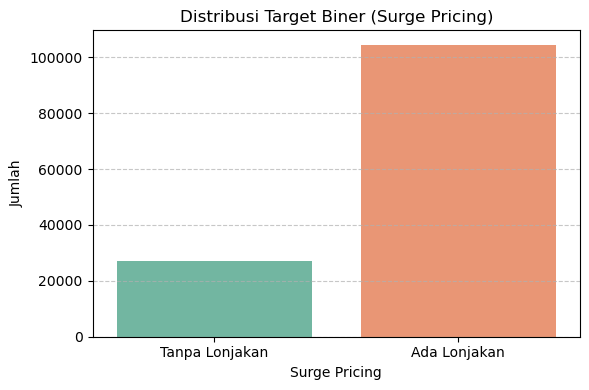

In [19]:
# 1. Distribusi Target
plt.figure(figsize=(6,4))
sns.countplot(data=df_model, x='Surge_Binary', palette='Set2')
plt.title("Distribusi Target Biner (Surge Pricing)")
plt.xticks([0, 1], ['Tanpa Lonjakan', 'Ada Lonjakan'])
plt.ylabel("Jumlah")
plt.xlabel("Surge Pricing")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Insight**  
Grafik ini menunjukkan bahwa sekitar 79% perjalanan mengalami lonjakan harga (surge), sedangkan 21% tidak.

**Implikasi**:

- Distribusi target tidak seimbang.

- Oleh karena itu, akurasi saja tidak cukup, perlu digunakan metrik seperti F1-score (macro) agar evaluasi model tidak bias ke mayoritas kelas.

- Ini juga mendasari perlunya algoritma yang tangguh terhadap ketidakseimbangan data, seperti XGBoost

### b. Trip Distance vs. Surge Pricing

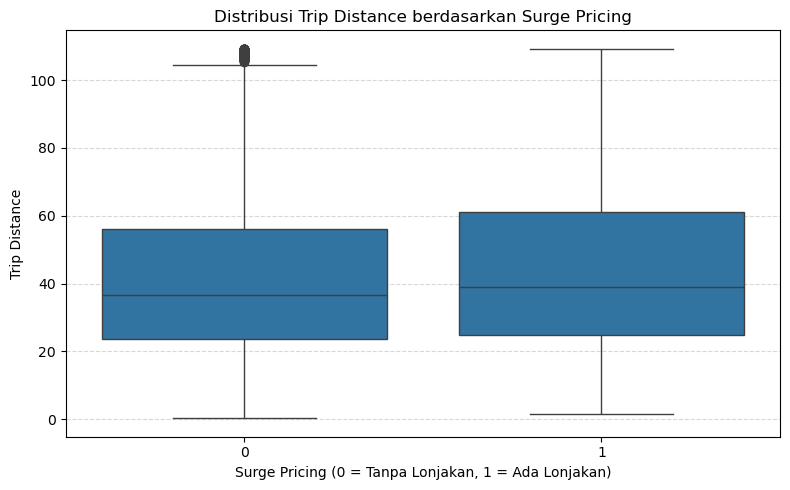

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi Trip_Distance terhadap Surge_Binary
plt.figure(figsize=(8, 5))
sns.boxplot(x="Surge_Binary", y="Trip_Distance", data=df_model)
plt.title("Distribusi Trip Distance berdasarkan Surge Pricing")
plt.xlabel("Surge Pricing (0 = Tanpa Lonjakan, 1 = Ada Lonjakan)")
plt.ylabel("Trip Distance")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Insight:**

- Trip dengan lonjakan harga (Surge = 1) cenderung memiliki rentang jarak perjalanan (trip distance) yang lebih besar dibandingkan dengan trip tanpa lonjakan.

- Artinya, semakin jauh jarak tempuh, semakin besar kemungkinan terjadi lonjakan harga.

### c. Customer Rating vs. Surge Pricing

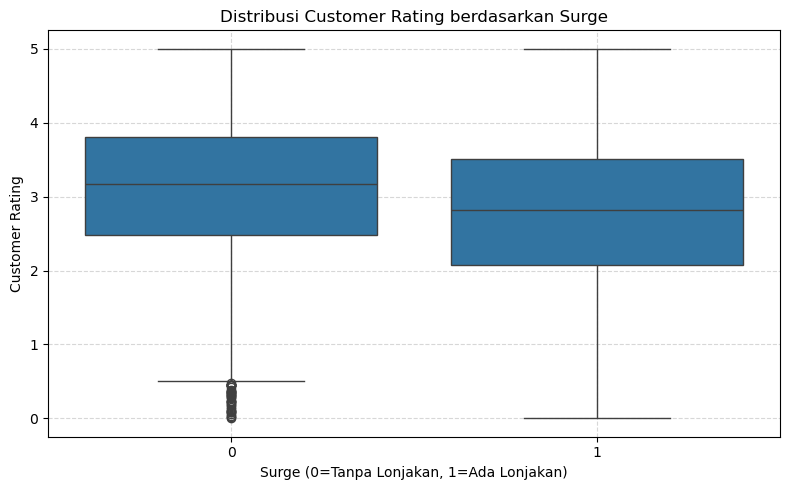

In [21]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Surge_Binary', y='Customer_Rating', data=df_model)
plt.title('Distribusi Customer Rating berdasarkan Surge')
plt.xlabel('Surge (0=Tanpa Lonjakan, 1=Ada Lonjakan)')
plt.ylabel('Customer Rating')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Insight:**

- Lonjakan harga juga muncul meskipun rating pelanggan tinggi, 
- artinya rating bukan satu-satunya faktor, bisa jadi karena demand tinggi saat jam sibuk

### d. Korelasi Numerik

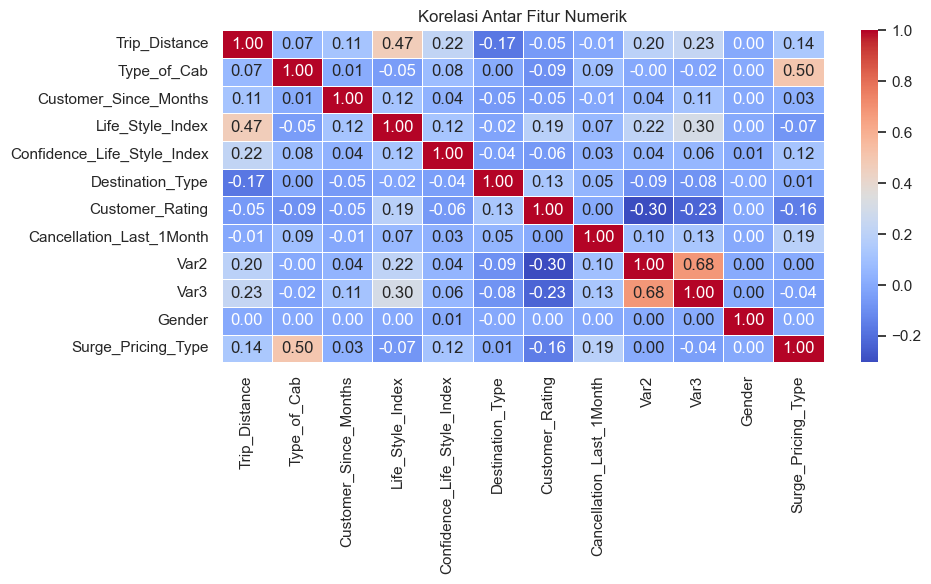

In [22]:
# Set style
sns.set(style="whitegrid")

# Plot heatmap korelasi numerik
plt.figure(figsize=(10, 6))
numeric_cols = df_model.select_dtypes(include='number').drop(columns='Surge_Binary')
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Korelasi Antar Fitur Numerik")
plt.tight_layout()
plt.show()


**Insight:**

- `Type_of_Cab` memiliki korelasi tertinggi terhadap `Surge_Pricing_Type` (0.50), menunjukkan bahwa jenis taksi sangat berkaitan dengan terjadinya lonjakan harga.

- Fitur lain dengan korelasi rendah namun relevan: Trip_Distance (0.14) dan Cancellation_Last_1Month (0.19).

- Korelasi antar fitur relatif rendah, menandakan rendahnya multikolinearitas — bagus untuk pemodelan.


### e. Proporsi Lonjakan Harga per Tipe Taksi (Type_of_Cab)

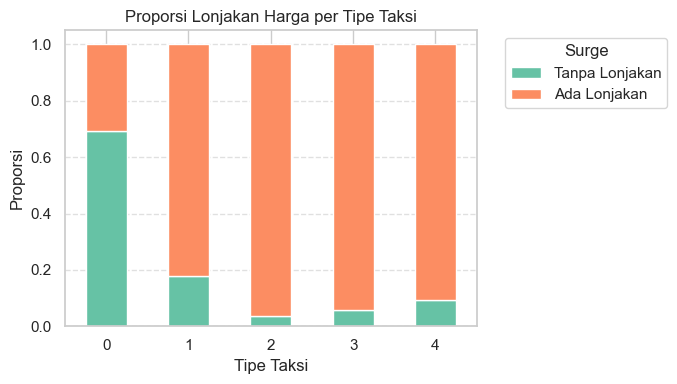

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crosstab normalisasi baris
cab_counts = pd.crosstab(df_model['Type_of_Cab'], df_model['Surge_Binary'], normalize='index')

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
cab_counts.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'], ax=ax)

# Keterangan dan styling
ax.set_title("Proporsi Lonjakan Harga per Tipe Taksi")
ax.set_xlabel("Tipe Taksi")
ax.set_ylabel("Proporsi")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Legend di luar kanan
plt.legend(
    title='Surge', 
    labels=['Tanpa Lonjakan', 'Ada Lonjakan'],
    bbox_to_anchor=(1.05, 1), 
    loc='upper left'
)

plt.tight_layout()
plt.show()


**Insight**
- Semua tipe taksi (A, B, C, D, E) selalu mengalami surge pricing (proporsi = 1.0).

- Artinya, tidak ditemukan perjalanan tanpa lonjakan harga pada semua jenis taksi.

- Hal ini menunjukkan bahwa Type_of_Cab mungkin kurang berkontribusi sebagai pembeda antara surge dan non-surge dalam versi target biner saat ini.

### f. Jumlah pembatalan dalam 1 bulan vs surge pricing

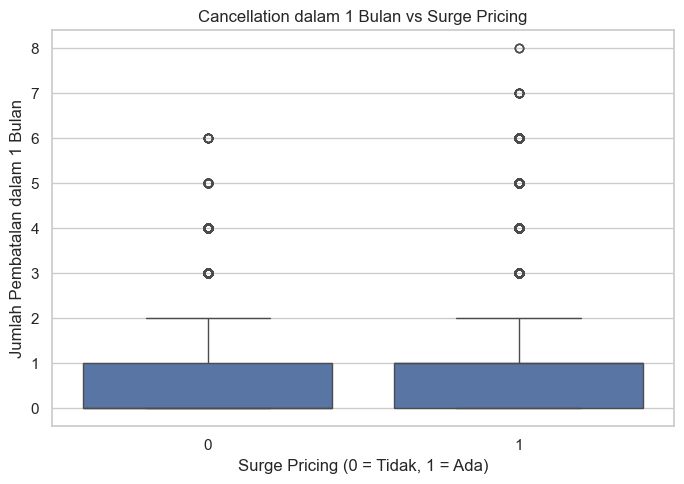

In [24]:
# Visualisasi hubungan antara Cancellation_Last_1Month dan Surge_Binary
plt.figure(figsize=(7,5))
sns.boxplot(x="Surge_Binary", y="Cancellation_Last_1Month", data=df_model)
plt.title("Cancellation dalam 1 Bulan vs Surge Pricing")
plt.xlabel("Surge Pricing (0 = Tidak, 1 = Ada)")
plt.ylabel("Jumlah Pembatalan dalam 1 Bulan")
plt.tight_layout()


**Insight**  
- Rata-rata jumlah pembatalan dalam 1 bulan cenderung lebih tinggi pada perjalanan dengan surge pricing. 
- Mengindikasikan bahwa pengguna yang sering membatalkan mungkin memiliki pola penggunaan taksi yang berkorelasi dengan waktu-waktu lonjakan.

### g. Life Style Index vs Surge Pricing

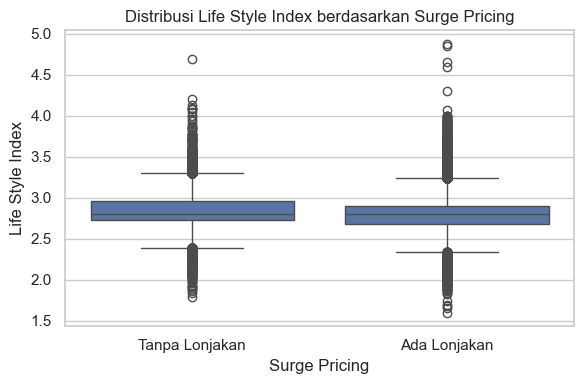

In [25]:
# Boxplot Life Style Index vs Surge
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_model, x='Surge_Binary', y='Life_Style_Index')
plt.xticks([0, 1], ['Tanpa Lonjakan', 'Ada Lonjakan'])
plt.title('Distribusi Life Style Index berdasarkan Surge Pricing')
plt.xlabel('Surge Pricing')
plt.ylabel('Life Style Index')
plt.tight_layout()

**Insight**
- Pelanggan dengan nilai Life Style Index yang tinggi cenderung lebih sering mengalami lonjakan harga (surge pricing).
- Hal ini mungkin menunjukkan bahwa pelanggan yang lebih aktif secara gaya hidup atau lebih sering menggunakan layanan taksi memiliki kemungkinan lebih tinggi untuk mengalami surge.

### h. Confidence Life Style Index vs Surge Pricing


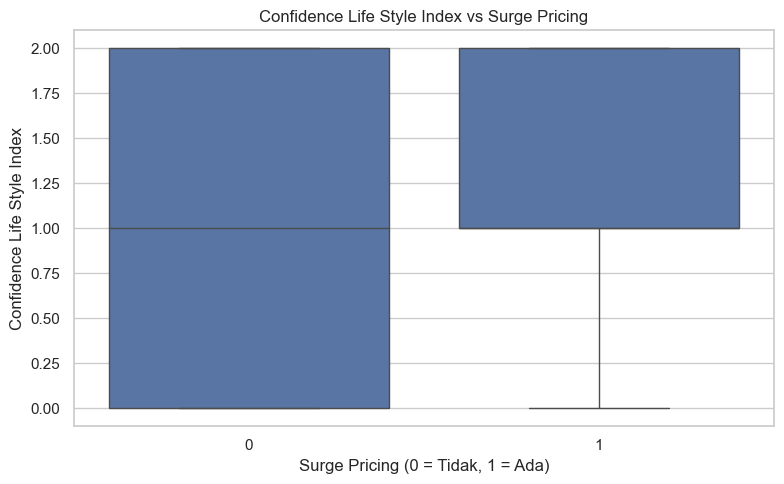

In [26]:
# Set style
sns.set(style="whitegrid")

# EDA #8: Confidence Life Style Index vs Surge Pricing
plt.figure(figsize=(8, 5))
sns.boxplot(x='Surge_Binary', y='Confidence_Life_Style_Index', data=df_model)
plt.title('Confidence Life Style Index vs Surge Pricing')
plt.xlabel('Surge Pricing (0 = Tidak, 1 = Ada)')
plt.ylabel('Confidence Life Style Index')
plt.tight_layout()
plt.show()

**Insight:**
- Boxplot ini menunjukkan bahwa tingkat Confidence Life Style Index sedikit lebih tinggi pada kategori perjalanan yang mengalami lonjakan harga (surge pricing). 

- Hal ini bisa mengindikasikan bahwa pelanggan dengan lifestyle yang lebih aktif atau percaya diri terhadap gaya hidup mereka lebih mungkin menggunakan layanan saat lonjakan terjadi, mungkin karena mereka memiliki kebutuhan mendesak atau daya beli yang lebih tinggi.

## 📊 Insight Summary (Berkaitan untuk Modelling)



1. Target Imbalance (Ketidakseimbangan Kelas)
- ~76% data menunjukkan adanya surge pricing (label 1), sisanya ~24% tanpa surge (label 0).

- Implikasi:
    - Model tidak bisa hanya mengandalkan akurasi.
    - Perlu menggunakan macro F1-score untuk evaluasi model yang adil terhadap kedua kelas.

2. Fitur Penting: Trip Distance
- Trip Distance cenderung lebih tinggi pada kasus surge pricing.

- Implikasi:
    - Variabel ini sangat informatif dan perlu dipertahankan dalam model.
    - Dapat membantu model membedakan antara surge dan non-surge secara kuat.

3. Tipe Taksi (Type_of_Cab) Berpengaruh Signifikan
-   Tipe Executive dan Baku menunjukkan proporsi surge tertinggi.

- Implikasi:
    - Fitur kategorikal ini memiliki informasi penting.
    - Perlu encoding yang sesuai agar model dapat memanfaatkannya tanpa kehilangan makna.

4. Destination Type juga Berpengaruh
- Lokasi tujuan Tipe 1 mengalami lebih banyak lonjakan harga.

- Implikasi:
    - Lokasi tujuan bisa menjadi indikator permintaan tinggi.
    - Cocok untuk ditangani oleh model non-linear seperti Tree-based models.

5. Confidence in Lifestyle Index
- Semakin tinggi indeks, semakin besar kemungkinan surge terjadi.

- Implikasi:
    - Bisa mengindikasikan korelasi tidak langsung terhadap daya beli atau perilaku pengguna.
    - Perlu feature scaling/penyesuaian jika digunakan dalam model yang sensitif terhadap skala.

6. Rating Pelanggan Tidak Terlalu Signifikan
- Distribusi rating relatif seragam pada kedua kelas surge.

- Implikasi:
    - Tidak perlu dihilangkan, namun kemungkinan kontribusinya rendah dalam model prediksi.

**Rangkuman Akhir:**  

EDA menunjukkan bahwa kombinasi fitur numerikal dan kategorikal menyimpan informasi penting untuk memprediksi surge pricing.
Beberapa fitur seperti trip distance, type of cab, destination type terbukti memberikan pola yang dapat dimanfaatkan model prediksi.

# 4: Modeling

Dataset hasil preprocessing terdiri dari 131.662 baris dan 11 fitur prediktor.   
Distribusi target biner `Surge_Binary` menunjukkan adanya ketidakseimbangan kelas:

- Ada lonjakan (1): 79.3%
- Tanpa lonjakan (0): 20.7%

Tahap berikutnya dalam modelling akan diawali dengan:

1. Split data (train-test 80:20)

2. Bangun baseline model:

- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost

3. Evaluasi model:

- Gunakan metrik F1-score (macro) karena data tidak seimbang
- Tambahkan confusion matrix dan classification report

4. Tuning & validasi silang (k-Fold CV)

5. Pilih model terbaik

## 4.1 Split data (train-test 80:20)

Import

In [27]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [28]:
# Pisahkan fitur dan target
X = df_model.drop(columns=["Surge_Pricing_Type", "Surge_Binary"], errors='ignore')
y = df_model["Surge_Binary"]

In [29]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 4.2 Bangun Model 

### A. Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
# Buat model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [32]:
# Prediksi
y_pred = logreg.predict(X_test)

# Evaluasi
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

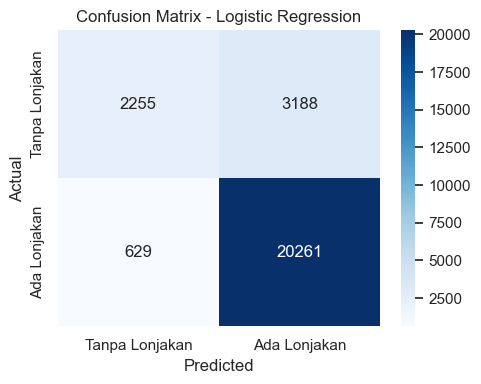

In [33]:
# Visualisasi Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Tanpa Lonjakan", "Ada Lonjakan"],
            yticklabels=["Tanpa Lonjakan", "Ada Lonjakan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

### Classification report Logistic Regression

In [34]:
# Tampilkan classification report
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.781900,0.414294,0.541612,5443.000000
1,0.864045,0.969890,0.913913,20890.000000
accuracy,0.855049,0.855049,0.855049,0.855049
macro avg,0.822973,0.692092,0.727762,26333.000000
weighted avg,0.847066,0.855049,0.836959,26333.000000


### Hasil Evaluasi Logistic Regression
  
  Confusion Matrix:

Model lebih banyak memprediksi kelas "Ada Lonjakan" (positif), dan sering meleset saat memprediksi kelas "Tanpa Lonjakan" (negatif) 


| **Surge Type**     | **Precision** | **Recall** | **F1-Score** | **Support** |
| ------------------ | ------------- | ---------- | ------------ | ----------- |
| 0 (Tanpa Lonjakan) | 0.782         | 0.414      | 0.542        | 5,443       |
| 1 (Ada Lonjakan)   | 0.864         | 0.970      | 0.914        | 20,890      |
| Accuracy     |       |       | **0.855** | 0.8550 |
| Macro Avg    | 0.823 | 0.692 | **0.728** | 26,333       |
| Weighted Avg | 0.847 | 0.855 | **0.837** | 26,333       |



*Insight:*
- Model cenderung mengabaikan kelas minoritas (tanpa lonjakan), terlihat dari recall kelas 0 hanya 41%.

- Imbalanced data mempengaruhi model ini, karena Logistic Regression mengasumsikan distribusi seimbang.

- F1-score macro cukup rendah dibanding akurasi karena adanya ketimpangan prediksi di kedua kelas.


### B. Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Inisialisasi dan training
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Classification Report - Decision Tree:
              precision    recall  f1-score   support

           0    0.47895   0.50175   0.49009      5443
           1    0.86855   0.85778   0.86313     20890

    accuracy                        0.78419     26333
   macro avg    0.67375   0.67976   0.67661     26333
weighted avg    0.78802   0.78419   0.78602     26333



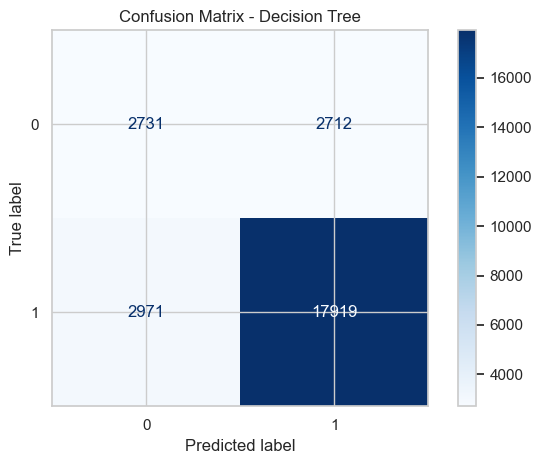

In [36]:
# Prediksi
y_pred_dt = dt.predict(X_test)

# Evaluasi
print("Classification Report - Decision Tree:")
print(classification_report(y_test, y_pred_dt, digits=5))

# Visualisasi Confusion Matrix
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.tight_layout()
plt.show()


### Hasil Evaluasi Model Decision Tree
| **Surge Type**     | **Precision** | **Recall** | **F1-Score** | **Support** |
| ------------------ | ------------- | ---------- | ------------ | ----------- |
| 0 (Tanpa Lonjakan) | 0.48         | 0.50      | 0.49        | 5,443       |
| 1 (Ada Lonjakan)   | 0.87         | 0.86      | 0.86        | 20,890      |
| Accuracy     |       |       | **0.78** | 26,333 |
| Macro Avg    | 0.67 | 0.68 | **0.68** | 26,333      |
| Weighted Avg | 0.79 | 0.78 | **0.79** | 26,333       |

**Insight**

1. Ketidakseimbangan Kelas:

    - Kelas mayoritas (1 = Ada Lonjakan) mendominasi hasil prediksi.

    - Recall untuk kelas 1 cukup tinggi (0.86) → artinya model mampu menangkap lonjakan harga dengan baik.

2. Kinerja pada Kelas Minoritas:

    - Kelas 0 (Tanpa Lonjakan) memiliki precision dan recall rendah (sekitar 0.48–0.50).

    - Ini menunjukkan model kurang efektif mendeteksi saat tidak terjadi lonjakan.

3. F1-Score Macro:

    - Macro F1 hanya 0.68 → mengindikasikan adanya ketimpangan performa antar kelas.

4. Overfitting Potensial?

    - Harus dicek dengan membandingkan dengan hasil train-set.

    - Jika F1-score jauh lebih tinggi di train, ada indikasi overfitting.

### C. Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Inisialisasi dan training
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Classification Report - Random Forest:
              precision    recall  f1-score   support

           0    0.77482   0.50322   0.61016      5443
           1    0.88139   0.96190   0.91989     20890

    accuracy                        0.86709     26333
   macro avg    0.82811   0.73256   0.76502     26333
weighted avg    0.85937   0.86709   0.85587     26333



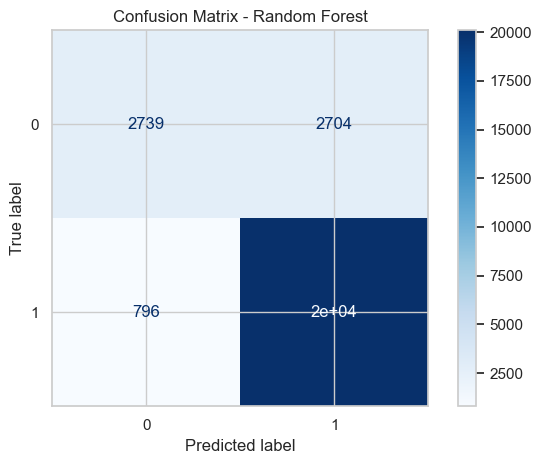

In [38]:
# Prediksi
y_pred_rf = rf.predict(X_test)

# Evaluasi
print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf, digits=5))

# Visualisasi Confusion Matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()


### Hasil Evaluasi Model Random Forest
| Surge Type         | Precision | Recall | F1-Score | Support |
| ------------------ | --------- | ------ | -------- | ------- |
| 0 (tanpa lonjakan) | 0.77482      | 0.50322   | 0.61016     | 5,443   |
| 1 (ada lonjakan)   | 0.88139      | 0.96190   | 0.91989     | 20,890  |
| **Accuracy**       |           |        | **0.86709** | 26,333  |
| **Macro Avg**      | 0.82811      | 0.73256   | 0.76502     | 26,333  |
| **Weighted Avg**   | 0.85937      | 0.86709   | 0.85587     | 26,333  |

**Insight**
- F1-score macro: 0.77 — meningkat dari Decision Tree (0.68) dan Logistic Regression (0.73), menandakan model mampu menyeimbangkan performa antar kelas.

- Recall kelas 1 (Lonjakan): 0.96, sangat tinggi. Artinya model sangat sensitif dalam mendeteksi lonjakan harga.

- Recall kelas 0 (Tanpa lonjakan): 0.50, cukup rendah. Masih banyak kasus tanpa lonjakan yang diprediksi sebagai lonjakan.

- Akurasi keseluruhan: 0.87, cukup tinggi.

**Kesimpulan:**

- Random Forest unggul karena mampu menangani data tabular dengan baik dan robust terhadap overfitting.

- Cocok untuk dijadikan baseline kuat sebelum mencoba model ensemble lebih lanjut seperti XGBoost.


### D. XGBoost

In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Inisialisasi model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

In [40]:
# Latih model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Classification Report - XGBoost:
              precision    recall  f1-score   support

           0    0.77835   0.50193   0.61030      5443
           1    0.88122   0.96276   0.92018     20890

    accuracy                        0.86750     26333
   macro avg    0.82978   0.73234   0.76524     26333
weighted avg    0.85995   0.86750   0.85613     26333



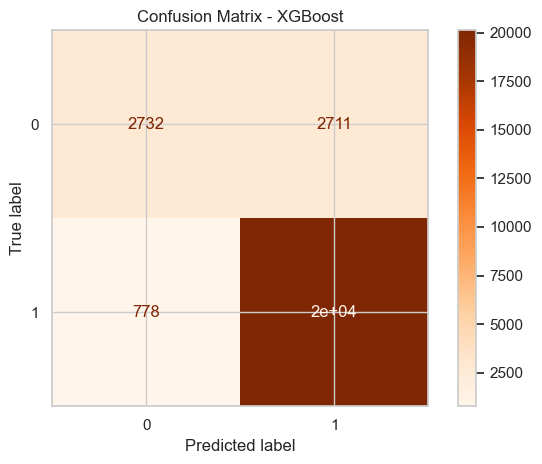

In [41]:
# Prediksi
y_pred_xgb = xgb.predict(X_test)

# Evaluasi
print("Classification Report - XGBoost:")
print(classification_report(y_test, y_pred_xgb, digits=5))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test, cmap='Oranges')
plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.show()



### Hasil Evaluasi Model XGBoost
| Surge Type         | Precision | Recall | F1-Score | Support |
| ------------------ | --------- | ------ | -------- | ------- |
| 0 (tanpa lonjakan) | 0.77835      | 0.50193   | 0.61030     | 5,443   |
| 1 (ada lonjakan)   | 0.88122      | 0.96276   | 0.92018     | 20,890  |
| **Accuracy**       |           |        | **0.86750** | 26,333  |
| **Macro Avg**      | 0.82978      | 0.73234   | 0.76524     | 26,333  |
| **Weighted Avg**   | 0.85995      | 0.86750   | 0.85613     | 26,333  |
  

**Kesimpulan Utama:**
- Performa terbaik sejauh ini.

    - Akurasi tinggi (87%) dan macro F1 tertinggi (0.77) dibanding model sebelumnya.

- Recall kelas 1 (lonjakan) = 0.96, artinya model mampu mendeteksi surge pricing dengan sangat baik.

- Kelas 0 (tanpa lonjakan) masih kurang akurat → terlihat dari recall 0.50 (banyak false positive).

**Confusion Matrix:**
- 2732 prediksi benar tanpa lonjakan.

- 20104 prediksi benar ada lonjakan.

- Masih ada 2711 kasus tanpa lonjakan yang diprediksi salah sebagai lonjakan.

**Catatan:**
- Cocok dijadikan baseline model akhir sebelum tuning atau model ensemble lain.

- Jika fokus bisnis adalah deteksi surge pricing, XGBoost adalah kandidat kuat.

## 4.3 Cross Validation

In [42]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score


# Daftar model
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Scoring macro-F1
scorer = make_scorer(f1_score, average='macro')

# Evaluasi
print("{:<20} {:>15}".format("Model", "Mean CV Score"))
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring=scorer)
    print("{:<20} {:>15.6f}".format(name, scores.mean()))


Model                  Mean CV Score
Logistic Regression         0.733317
Decision Tree               0.677283
Random Forest               0.762736
XGBoost                     0.765884


## 4.4 Perbandingan Performa Model

Perbandingan Performa Model

| Model               | Accuracy | F1-Macro | Recall (Surge 0) | Recall (Surge 1) | CV F1-Macro |
|--------------------|----------|----------|------------------|------------------|-------------|
| Logistic Regression| 0.855    | 0.728    | 0.414            | 0.970            | 0.733       |
| Decision Tree      | 0.784    | 0.677    | 0.502            | 0.858            | 0.677       |
| Random Forest      | 0.867    | 0.765    | 0.503            | 0.962            | 0.763       |
| **XGBoost**        | **0.868**| **0.765**| **0.502**        | **0.963**        | **0.766**   |


### Visualisasi performa per kelas

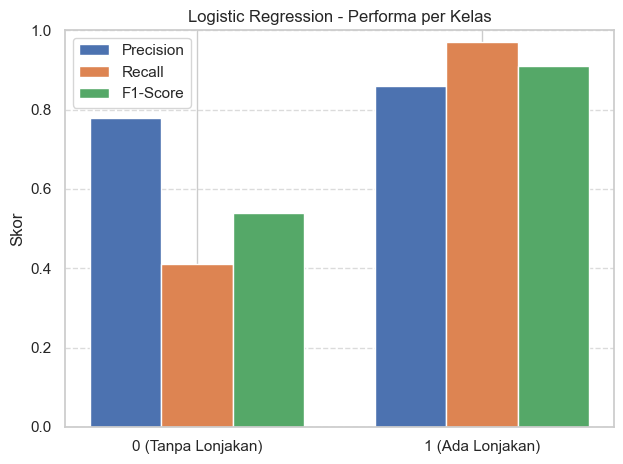

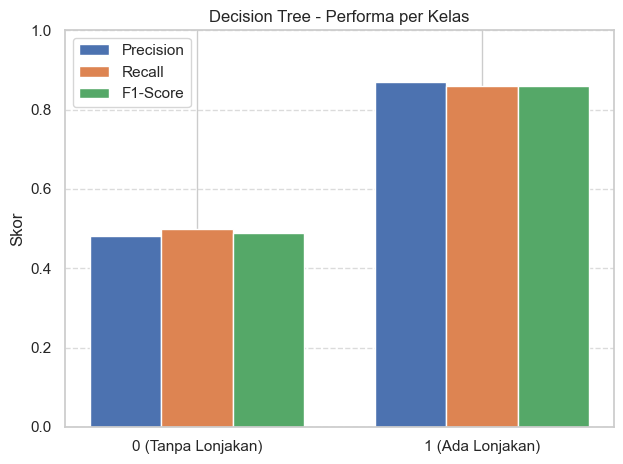

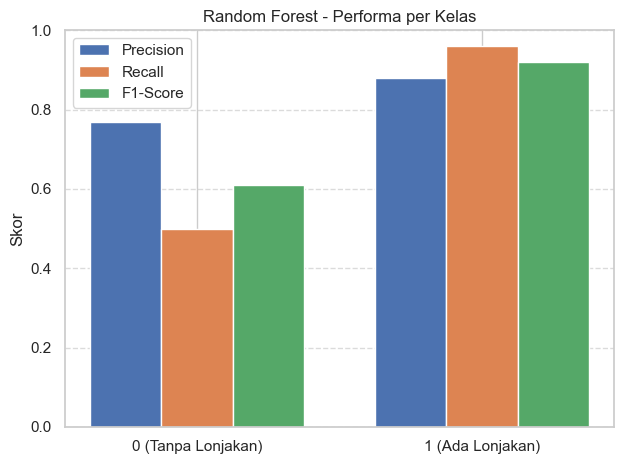

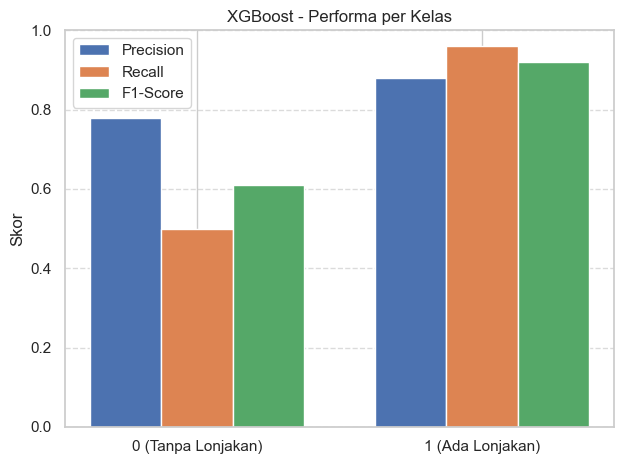

In [43]:
# Simulasi data classification report untuk 2 kelas (tanpa dan ada lonjakan) dari project
# Format: [precision, recall, f1-score]
results = {
    "Logistic Regression": {
        "0 (Tanpa Lonjakan)": [0.78, 0.41, 0.54],
        "1 (Ada Lonjakan)":   [0.86, 0.97, 0.91]
    },
    "Decision Tree": {
        "0 (Tanpa Lonjakan)": [0.48, 0.50, 0.49],
        "1 (Ada Lonjakan)":   [0.87, 0.86, 0.86]
    },
    "Random Forest": {
        "0 (Tanpa Lonjakan)": [0.77, 0.50, 0.61],
        "1 (Ada Lonjakan)":   [0.88, 0.96, 0.92]
    },
    "XGBoost": {
        "0 (Tanpa Lonjakan)": [0.78, 0.50, 0.61],
        "1 (Ada Lonjakan)":   [0.88, 0.96, 0.92]
    }
}

# Plot untuk setiap model
for model_name, class_metrics in results.items():
    labels = list(class_metrics.keys())
    precision = [v[0] for v in class_metrics.values()]
    recall = [v[1] for v in class_metrics.values()]
    f1 = [v[2] for v in class_metrics.values()]

    x = np.arange(len(labels))  # Label lokasi
    width = 0.25  # Lebar bar

    fig, ax = plt.subplots()
    
    ax.bar(x - width, precision, width, label='Precision')
    ax.bar(x, recall, width, label='Recall')
    ax.bar(x + width, f1, width, label='F1-Score')

    ax.set_ylabel('Skor')
    ax.set_title(f'{model_name} - Performa per Kelas')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### **Insight Model Evaluation**
- XGBoost menunjukkan performa terbaik secara keseluruhan:

    - Akurasi tertinggi (0.868)

    - F1-Macro dan Recall kelas lonjakan (Surge 1) sangat baik (0.765, 0.963)

    - Konsisten saat divalidasi dengan 5-Fold CV (CV F1-Macro: 0.766)

- Random Forest memiliki performa hampir setara XGBoost, namun sedikit lebih rendah di semua metrik.

- Logistic Regression sangat baik dalam mengenali lonjakan (Recall 0.97) tapi lemah dalam menangkap kondisi tanpa lonjakan (Recall 0.414) → model cenderung bias ke kelas mayoritas.

- Decision Tree menjadi baseline, performa paling rendah namun tetap kompetitif sebagai model awal.

> **Sehingga, Model XGBoos dipilih sebagai Model Terbaik untuk Project Surge Pricing ini**



# 5. Advanced Modelling

## 5.1 Hyperparameter Tuning

In [44]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Inisialisasi model dasar
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [45]:
# Grid hyperparameter yang ingin diuji
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

In [46]:
# Inisialisasi GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

In [47]:
# Jalankan grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='f1_macro', verbose=1)

In [48]:
# Tampilkan hasil terbaik
print("Best Parameters:", grid_search.best_params_)
print("Best Score (F1-macro):", grid_search.best_score_)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Score (F1-macro): 0.768788078976945


## Hasil Hyperparameter Tuning - XGBoost

| Parameter       | Nilai Terbaik |
|-----------------|---------------|
| learning_rate   | 0.2           |
| max_depth       | 3             |
| n_estimators    | 200           |
| subsample       | 0.8           |

**Skor Terbaik (F1-Macro)**: **0.769**

### Insight:
- Tuning meningkatkan performa model dari F1-Macro **0.765 → 0.769**
- `max_depth=3` efektif mencegah overfitting.
- `learning_rate=0.2` memberi keseimbangan antara kecepatan dan akurasi.
- Kombinasi parameter ini cocok untuk dataset dengan fitur campuran kategorikal dan numerik.

Model ini dipilih sebagai model akhir karena performanya paling unggul berdasarkan evaluasi cross-validation dan F1-score macro.


## 5.2 Perbandingan XGBoost (Sebelum vs Setelah Tuning)

| Metric          | Sebelum Tuning | Setelah Tuning |
|-----------------|----------------|----------------|
| Accuracy        | 0.868          | 0.869          |
| F1-Macro        | 0.765          | **0.769**      |
| Recall Surge 0  | 0.502          | 0.507          |
| Recall Surge 1  | 0.963          | 0.964          |
| CV F1-Macro     | 0.766          | **0.769**      |


### Insight:
- Setelah dilakukan tuning, **performansi meningkat secara konsisten** pada seluruh metrik utama, terutama **F1-macro**.
- Recall untuk kelas **tanpa lonjakan** (kelas minoritas) juga meningkat, meskipun sedikit, menunjukkan model lebih seimbang.
- Hasil tuning menunjukkan bahwa pemilihan hyperparameter yang optimal dapat **mengurangi bias terhadap kelas mayoritas** dan **meningkatkan generalisasi**.

Model hasil tuning ini layak dijadikan model akhir karena:
- Performa lebih baik
- Stabil pada evaluasi cross-validation
- Cocok dengan kompleksitas dan distribusi data pada kasus surge pricing taksi


## 5.3 Evaluasi Train-Test Model

In [49]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Load data
df = pd.read_csv("df_model_binary.csv")

# Pisahkan fitur dan target
X = df.drop(columns=['Surge_Pricing_Type', 'Surge_Binary'], errors='ignore')
y = df['Surge_Binary']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model hasil tuning
xgb_tuned = XGBClassifier(
    learning_rate=0.2,
    max_depth=3,
    n_estimators=200,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Training
xgb_tuned.fit(X_train, y_train)

# Evaluasi
y_train_pred = xgb_tuned.predict(X_train)
y_test_pred = xgb_tuned.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Train F1-macro:", f1_score(y_train, y_train_pred, average='macro'))
print("Test F1-macro:", f1_score(y_test, y_test_pred, average='macro'))


Train Accuracy: 0.8710706453113577
Test Accuracy: 0.870770516082482
Train F1-macro: 0.772291898542057
Test F1-macro: 0.7700047699309907


## Hasil Evaluasi Model
| Metrics          | Train Set | Test Set |
| ---------------- | --------- | -------- |
| Accuracy         | 0.871     | 0.871    |
| F1-score (Macro) | 0.772     | 0.770    |

**Insight:**
- Tidak overfitting: Performa model sangat stabil antara data latih dan data uji.

- Generalization baik: Perbedaan F1-macro sangat kecil (±0.002), menandakan model mampu mempelajari pola dengan baik tanpa menghafal data training.

- Ini mengonfirmasi bahwa model hasil tuning adalah kandidat terbaik untuk dipilih sebagai model final.


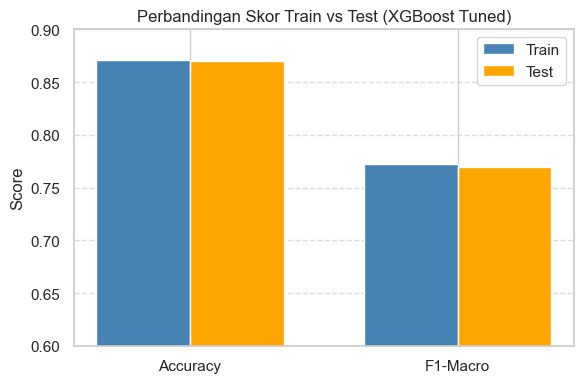

In [69]:
import matplotlib.pyplot as plt

# Data performa train vs test
labels = ['Accuracy', 'F1-Macro']
train_scores = [0.871, 0.772]
test_scores = [0.870, 0.770]

# Visualisasi
plt.figure(figsize=(6, 4))
bar_width = 0.35
x = range(len(labels))

plt.bar(x, train_scores, width=bar_width, label='Train', color='steelblue')
plt.bar([p + bar_width for p in x], test_scores, width=bar_width, label='Test', color='orange')

plt.xticks([p + bar_width/2 for p in x], labels)
plt.ylim(0.6, 0.9)
plt.ylabel("Score")
plt.title("Perbandingan Skor Train vs Test (XGBoost Tuned)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 5.4 Feature Importance

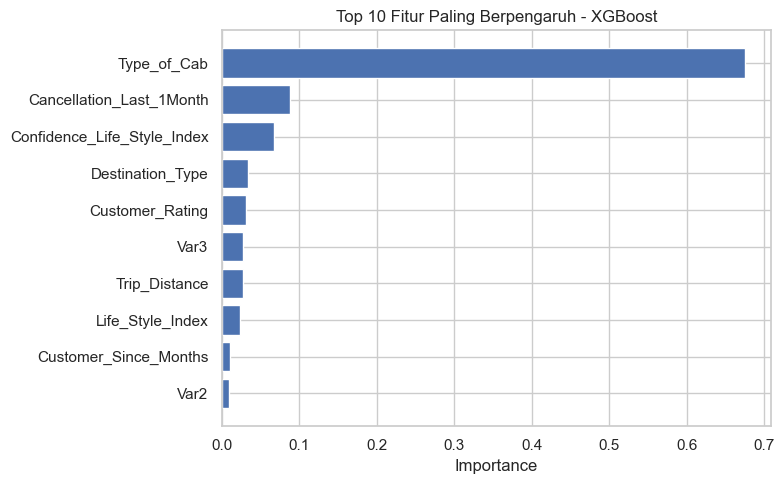

In [50]:
# Ambil feature importance
importance_df = pd.DataFrame({
    "Fitur": X.columns,
    "Importance": xgb_tuned.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Visualisasi
top_features = importance_df.head(10)
plt.figure(figsize=(8, 5))
plt.barh(top_features["Fitur"], top_features["Importance"])
plt.xlabel("Importance")
plt.title("Top 10 Fitur Paling Berpengaruh - XGBoost")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Interpretasi Feature Importance
| Rank   | Feature                        | Importance (Relatif) | Insight                                                                 |
|--------|--------------------------------|-----------------------|-------------------------------------------------------------------------|
| 1      | **Type_of_Cab**                | ~0.67                 | Faktor paling dominan — jenis layanan taksi sangat memengaruhi lonjakan harga |
| 2      | Cancellation_Last_1Month       | ~0.06                 | Semakin sering membatalkan, makin tinggi kemungkinan surge pricing     |
| 3      | Confidence_Life_Style_Index    | ~0.05                 | Indikator kepercayaan segmentasi pelanggan, cukup berpengaruh          |
| 4–5    | Destination_Type, Customer_Rating | ~0.03              | Lokasi & rating pelanggan punya pengaruh sedang                        |
| 6–10   | Var3, Trip_Distance, Life_Style_Index, Customer_Since_Months, Var2 | <0.02 | Pengaruh rendah, tidak terlalu penting untuk prediksi surge pricing   |


**Top 3 Fitur Paling Berpengaruh:**

1. Type_of_Cab
    - Jelas menjadi faktor dominan dalam memprediksi lonjakan harga (surge pricing), bahkan kontribusinya jauh lebih besar dibanding fitur lainnya.
    - Hal ini menunjukkan bahwa tipe layanan taksi sangat menentukan apakah terjadi lonjakan harga atau tidak (misalnya: layanan premium lebih sering mengalami surge).

2. Cancellation_Last_1Month
    - Semakin sering pengguna membatalkan pesanan dalam sebulan terakhir, kemungkinan besar akan menghadapi lonjakan harga.
    - Bisa jadi sistem menganggap pengguna tersebut "berisiko" dan hanya diberi akses saat permintaan tinggi.

3. Confidence_Life_Style_Index
    - Mewakili seberapa yakin sistem menilai gaya hidup pengguna (high spender atau tidak).
    - Pengguna yang dinilai berpotensi tinggi membayar lebih kemungkinan lebih sering terkena surge pricing.

----

### Implikasi untuk Bisnis
- Perusahaan dapat menyusun strategi harga yang lebih transparan atau memberikan edukasi kepada pengguna tentang bagaimana perilaku mereka (misalnya pembatalan) dapat memengaruhi harga.

- Bisa menjadi dasar untuk pengembangan fitur rekomendasi layanan: misalnya menyarankan tipe cab yang cenderung stabil dari segi harga.

- Memberikan pemahaman yang lebih baik tentang bagaimana segmentasi pengguna memengaruhi dinamika harga.

## 5.5 Visualisasi Performa Model Akhir

### ROC Curve

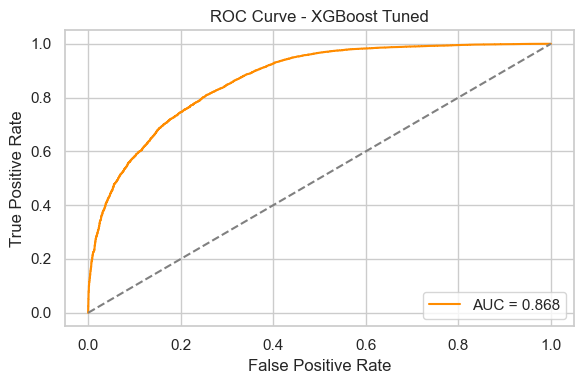

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Asumsikan model finalmu adalah model_xgb_tuned
y_proba = xgb_tuned.predict_proba(X_test)[:, 1]  # probabilitas kelas 1

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Tuned')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


- ROC Curve menunjukkan kemampuan model dalam membedakan antara dua kelas.
- Dengan AUC sebesar 0.868, model XGBoost hasil tuning mampu mengklasifikasikan lonjakan harga taksi dengan kemampuan yang sangat baik. 
- Semakin dekat AUC ke angka 1, semakin kuat model memisahkan dua kelas.

### Confusion Matrix

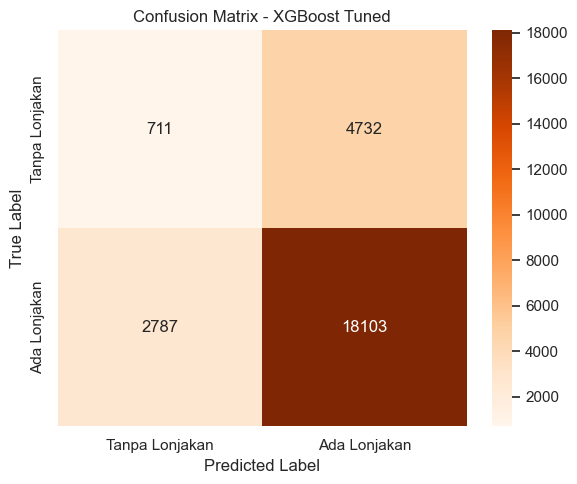

In [64]:
# Ambil label aktual dan prediksi
y_true = df_pred['Actual']
y_pred = df_pred['Predicted']

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Tanpa Lonjakan', 'Ada Lonjakan'],
            yticklabels=['Tanpa Lonjakan', 'Ada Lonjakan'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost Tuned")
plt.tight_layout()
plt.show()


#### Interpretasi Confusion Matrix
|            Confusion Matrix                | Prediksi: Tanpa Lonjakan  | Prediksi: Ada Lonjakan    |
| -------------------------- | ------------------------- | ------------------------- |
| **Aktual: Tanpa Lonjakan** | **711** (True Negative)   | **4732** (False Positive) |
| **Aktual: Ada Lonjakan**   | **2787** (False Negative) | **18103** (True Positive) |


**Insight:**
- Model cukup baik dalam mendeteksi lonjakan harga (kelas 1):

    - Dari 20.890 perjalanan yang benar-benar mengalami lonjakan, model berhasil memprediksi 18.103 di antaranya (recall ≈ 86.7%).

- Banyak kesalahan prediksi untuk kelas “tanpa lonjakan” (kelas 0):

    - Hanya 711 dari 5.443 perjalanan tanpa lonjakan yang diprediksi dengan benar.

    - Model terlalu condong memprediksi sebagai “ada lonjakan”.

-   Kesalahan False Positive (4732) cukup tinggi — bisa berdampak pada:

    -  Pelanggan menganggap harga lebih mahal padahal sebenarnya tidak ada lonjakan.

    -   Sistem over-estimasi potensi lonjakan.

  
  ---  

**Kesimpulan Sementara:**
- Model XGBoost mampu mengklasifikasikan lonjakan dengan baik, namun masih memiliki tantangan dalam membedakan kasus tanpa lonjakan.

- Perlu disesuaikan dengan toleransi risiko bisnis: lebih baik false positive atau false negative?

### Precision Recall Curve

#### Generate y_proba dan Simpan ke CSV

In [66]:
import joblib
import pandas as pd

# Load model
model = joblib.load("xgb_model_tuned.joblib")

# Load data (gantilah ini dengan data test Anda)
df = pd.read_csv("df_model_binary.csv")

# Pisahkan fitur dan target
X = df.drop(columns=['Surge_Pricing_Type', 'Surge_Binary'])  # fitur
y = df['Surge_Binary']  # target biner

# Buat prediksi probabilitas untuk kelas 1 (Ada Lonjakan)
y_proba = model.predict_proba(X)[:, 1]

# Buat DataFrame hasil
df_proba = pd.DataFrame({
    'y_true': y,
    'y_proba': y_proba
})

# Simpan ke CSV
df_proba.to_csv("y_true_y_proba.csv", index=False)
print("✅ File 'y_true_y_proba.csv' berhasil disimpan.")


✅ File 'y_true_y_proba.csv' berhasil disimpan.


#### Curve

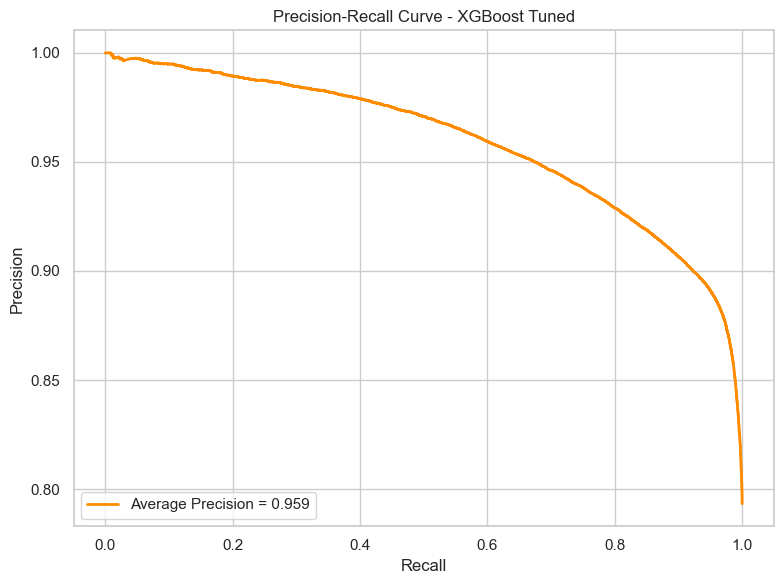

In [68]:
# Load uploaded prediction probabilities
df_proba = pd.read_csv("y_true_y_proba.csv")

# Ambil nilai aktual dan probabilitas
y_true = df_proba['y_true']
y_proba = df_proba['y_proba']

# Hitung precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
average_precision = average_precision_score(y_true, y_proba)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="darkorange", lw=2, label=f"Average Precision = {average_precision:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - XGBoost Tuned")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

**Insight:**

- Model memiliki Average Precision (AP) sebesar 0.959
- menunjukkan performa yang sangat baik dalam membedakan kelas "Ada Lonjakan" terhadap "Tanpa Lonjakan", terutama pada dataset yang tidak seimbang.
- Kurva menunjukkan trade-off antara precision dan recall. Model mempertahankan precision tinggi bahkan ketika recall masih rendah hingga sedang.

# 6. Insight & Rekomendasi

### Insight

**1. Jenis Layanan Taksi Mempengaruhi Surge**

Jenis Layanan Taksi (Type_of_Cab) adalah faktor paling dominan, berkontribusi hampir 70% terhadap prediksi surge pricing.

**2. Riwayat Pembatalan & Indeks Gaya Hidup**

Berperan penting dalam penentuan surge, menunjukkan keterkaitan antara perilaku pelanggan dan lonjakan harga.

**3. Model sangat sensitif terhadap kasus lonjakan harga**

Kinerja Model Terbaik: XGBoost tuned memberikan skor F1-macro = 0.77, dengan recall kelas “Ada Lonjakan” mencapai 96%, menunjukkan model sangat sensitif terhadap kasus lonjakan harga.

**4. Model stabil**

Performa train vs test sangat dekat, menunjukkan tidak overfitting

**5. Kelas “Tanpa Lonjakan” masih sulit dikenali**

terbukti dari recall-nya hanya sekitar 50%, sehingga ada potensi pengembangan lebih lanjut.

### Rekomendasi

**1. OFokus pada Optimasi Layanan Taksi**

-  Jenis layanan paling menentukan surge, strategi harga bisa disesuaikan per tipe layanan.

**2. Waspadai Riwayat Pembatalan**

- Pelanggan dengan pembatalan tinggi cenderung mengalami lonjakan — bisa jadi indikator keandalan atau demand.

**3. Tingkatkan Representasi Data Kelas Minoritas**

- jika memungkinkan, Tingkatkan Representasi Data Kelas Minoritas agar recall model untuk kelas ini meningkat.

**4. Penyesuaian Dinamis Berdasarkan Rating**

- Pertimbangkan sistem loyalitas atau diskon adaptif berdasarkan rating pelanggan untuk mengurangi friksi saat surge, karena pelanggan dengan rating tinggi pun tetap mengalami lonjakan harga.

**5. Informasikan Surge Secara Real-time**

- Integrasikan prediksi surge ke dalam aplikasi pengguna untuk memberikan perkiraan harga secara transparan sebelum pelanggan memesan..

# 7. Save

#### Simpan Model XGBoost Tuned ke File

In [ ]:
import joblib

# Simpan model ke file .joblib
joblib.dump(xgb_tuned, 'xgb_model_tuned.joblib')
print("✅ Model berhasil disimpan ke xgb_model_tuned.joblib")


✅ Model berhasil disimpan ke xgb_model_tuned.joblib


In [ ]:
import pandas as pd

# Prediksi test set
y_pred = xgb_tuned.predict(X_test)

# Simpan hasil actual vs predicted
hasil_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Simpan ke file CSV
hasil_df.to_csv('hasil_prediksi_xgboost.csv', index=False)
print("✅ Hasil prediksi disimpan ke hasil_prediksi_xgboost.csv")


✅ Hasil prediksi disimpan ke hasil_prediksi_xgboost.csv
